### **Study notes - Time series modelling**

_Based on_

_https://online.stat.psu.edu/stat510/ and_

_Shumway, R., Stoffer, D. (2011). Time series analysis and its applications, with R examples, 3rd edition. Springer New York Dordrecht Heidelberg London. e-ISBN 978-1-4419-7865-3_

These notes aim to explain some basic principles of time series modelling in a practical way, but without avoiding critical theoretical details. It's a summary of (hopefully) **understandable explanations** of key ideas, and not just a plain presentation of concepts, which is often what I've found (and struggled with) in many textbooks.

#### **What are time series, and why are they different from other data sets?**

A time series is just a sequence of measurements of a variable (GDP, wind speed, population size, no. users, no. transactions, etc.) over time, where every data point has a time associated with it (typically called a 'time stamp'). Here's a manual example:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

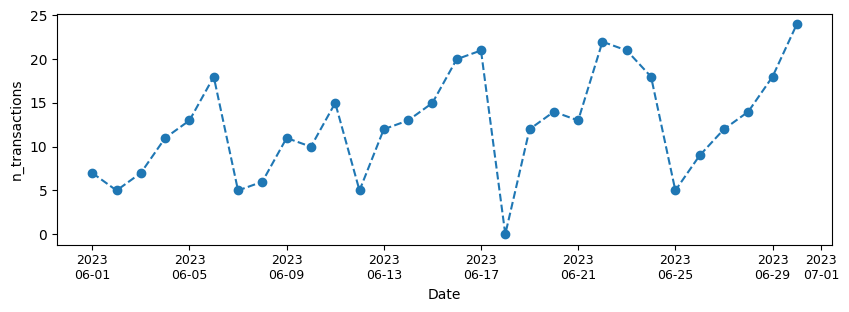

In [2]:
daily_transactions = pd.DataFrame({
    'date': pd.date_range(start='2023-06-01', end='2023-06-30', freq='D'),
    'n': [7, 5, 7, 11, 13, 18, 5, 6, 11, 10, 15, 5, 12, 13, 15, 20, 21, 0, 12, 14, 13, 22, 21, 18, 5, 9, 12, 14, 18, 24],
})

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(daily_transactions['date'], daily_transactions['n'], linestyle='--', marker='o')
ax.set_ylabel('n_transactions')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%m-%d'))
ax.tick_params(axis='x', labelsize=9)
ax.set_xlabel('Date')
plt.show()

When variables are measured over time, data points that are close to each other are unlikely to be independent. This non-independence prevents the use classical statistical approaches (OLS, ANOVA, etc.) to model temporal trends in this data. For instance, regressing a variable $x$, which we have measured over time, onto time $t$ using a model like $x = \beta_0 + \beta_1t + \epsilon$ would very likely have _autocorrelated_ residuals due to their temporal proximity. With the above data, that would look like this:

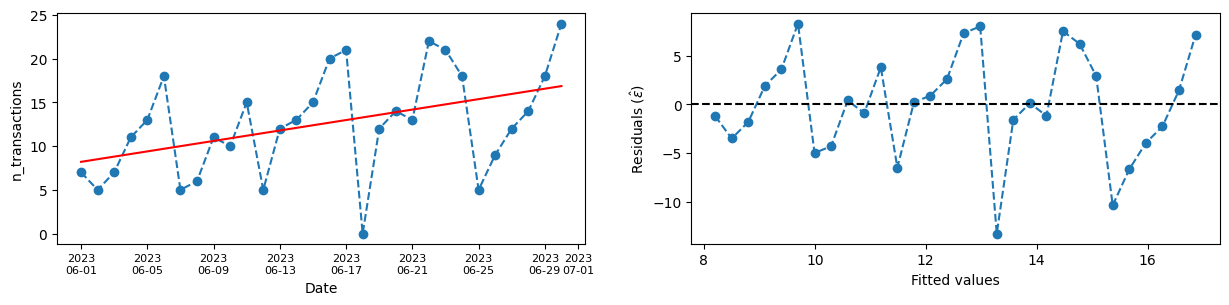

In [3]:
daily_transactions['date_num'] = (daily_transactions['date'] - pd.to_datetime('2023-06-01')).dt.days

X = daily_transactions['date_num'].values.reshape(-1, 1) 
y = daily_transactions['n'].to_numpy()

model = LinearRegression()
model.fit(X, y)
ypred = model.predict(X)
epsilon_hat = y - ypred 

fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax[0].plot(daily_transactions['date'], daily_transactions['n'], linestyle='--', marker='o', label='data')
ax[0].plot(daily_transactions['date'], ypred, color='red', label='model')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('n_transactions')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y\n%m-%d'))
ax[0].tick_params(axis='x', labelsize=8)
ax[1].plot(ypred, epsilon_hat, marker='o', linestyle='--')
ax[1].axhline(y=0, color='black', linestyle='--')
ax[1].set_xlabel('Fitted values')
ax[1].set_ylabel(r'Residuals ($\hat{\epsilon})$')
plt.show()

Clearly, residuals are autocorrelated, so a simple OLS doesn't work because we'd violate the OLS assumption of independent residuals. The strong residual autocorrelation also indicates there's something major missing from this OLS model, namely the fact that datapoints are **not independent** in time. That is, high values tend to be surrounded by high values, and low values tend to be surrounded by low values. Further, this 'inertia' likely results from underlying *mechanisms* that keep high values high and low values low, and this happens throughout the entire time series.

#### **Autoregressive time series models**

So an OLS of $x$ on $t$ doesn't work because of autocorrelation. However, if we reframe the problem by saying that $x$ is a function of its own past values, $x_t = f(x_{t-1}, x_{t-2}, ...)$, we could use autocorrelation to model $x$'s temporal evolution. We're basing this on the assumption that the response variable itself somehow 'stores' all the effects of its driving factors, and that we can use that regularity to predict what's going to happen next. Obviously, this will only succeed if those regularities really do exist and are strong enough, or in other words, if there really is enough **structure** in the data.

Shumway & Stoffer (2011) use the word *smoothness* to refer to the fact that time series with autocorrelation have values that don't just move up and down haphazardly, but rather seem 'tied' to past observations, either positively or negatively. Thus, the goal of any mathematical model of a time series is to mimic that smoothness.

##### **Notation**

A time series can be represented as a sequence of values $x_{1}$, $x_{2}$, ..., $x_{n}$, each of which is a **realization** of an underlying stochastic process. $x_{t}$ represents any particular value along that sequence, at some time $t$. Past or future values of the series are denoted as $x_{t-1}$, $x_{t-2}$, $x_{t-h}$, $x_{t+1}$, etc., where $t-1$, $t-2$, $t-h$, $t+h$ etc. indicate the number of time units we're looking into the past or the future. The number being subtracted or added to $t$ in the subscripts is the **lag**, denoted as $h$ whenever we refer to an unknown lag.

##### **Autoregressive (AR) models are meant to represent underlying stochastic processes**

The simplest AR model is an AR(1), an autoregressive model of order 1: $x_{t}=\delta+\phi_{1}~x_{t-1}+w_{t}$, where $x_{t}$ is the current value, $x_{t-1}$ is the previous value, $\delta$ = a constant term (like a bias), $\phi$ = autocorrelation coefficient for lag 1, and $w_{t}$ is *random noise*.

The last term $w_{t}$ is analogous to $\epsilon_i$ in OLS - it represents the *stochastic nature* of the model. This means that $w$ is what turns $x$ into a random variable, and each observation in the time series $x_t$ into a *realization* of that random variable. And like $\hat{\epsilon}_i = y_i - \hat{y}_i$ in OLS, when we fit an autoregressive model, $\hat{w}_t = x_t - \hat{x}_t$, that is, we use the observed residuals to get estimate $w_t$.

Since $w_t$ is random, we need a distribution for it, and in many cases it's useful to assume a normal distribution mean 0 and a variance of some value $\sigma_w$ (which we estimate from the data as $\hat{w}_t$, as mentioned above). Further, we also assume that, across all values of $t$, that distribution is *the same* (e.g., always normal, instead of normal for certain values of $t$ and exponential for others). Also, we assume that the properties (mean, variance, ...) of $w_t$'s distribution at one value of $t$ are disconnected from those at any other value of $t$. Formally, we say that $w_{t}$ is *'iid'* - **independent and identically distributed**. If we didn't assume that we'd have to use the data to estimate the parameters of a different distribution for $w_{t}$ at every $t$, and that's just too many parameters for any data set.

With this bit of theory, here's an example of how to fit an AR(1) model to a simple toy dataset, along with some other useful intuitions. The example data is generated using a AR(1) stochastic process with known parameters, which of course in practice is not possible. This is useful though because we can check how good parameter estimates are by comparing to the actual parameter values.

In [6]:
def generate_toy_data(n, x_0, delta, phi_1, sigma):    
    np.random.seed(10)    
    w = np.random.normal(0, sigma, size=n)
    x = np.zeros(n)
    x[0] = x_0 + w[0] # to generate the data, x_0 must be known
    for t in range(1, n):
        x[t] = delta + phi_1*x[t-1] + w[t] # stochastic process x_t = delta + phi_1*x_{t-1} + w_t
    return x


def fit_ar_1(x):
    model = ARIMA(x, order=(1, 0, 0))
    model_fit = model.fit()
    return model_fit

def compute_fitted_values(x, model_fit):
    phi_hat = model_fit.params[1]
    delta_hat = model_fit.params[0]
    fitted_values = np.zeros(len(x))
    fitted_values[0] = x[0]
    for t in range(1, len(x)):
        fitted_values[t] = delta_hat + phi_hat*x[t-1]
    return fitted_values

def plot_example(x, model_fit, plot_naive_model=True):

    fitted_values = compute_fitted_values(x, model_fit)

    fig = plt.figure(figsize=(15, 7))
    gs = fig.add_gridspec(2, 2)
    ax0 = fig.add_subplot(gs[0, :])
    ax0.set_title(f'Data and fitted AR(1) model, mse = {model_fit.mse:.3f}')
    ax0.plot(x, marker='o', markersize=4, linestyle='--', markerfacecolor='None', label='data')
    ax0.plot(fitted_values, color='red', marker='x', linestyle='--', markersize=5, linewidth=1, label='model')
    if plot_naive_model:
        ax0.plot(range(1, len(x)) , x[:-1], color='black', linewidth=1, linestyle='--', label=r'naive model $x_t = x_{t-1}$')
    ax0.set_xlabel('t')
    ax0.set_ylabel('x')
    ax0.text(x=0, y=-5, s=f'$\\hat{{\\delta}} = {model_fit.params[0]:.3f} \\pm {model_fit.bse[0]:.3f}$')
    ax0.text(x=0, y=-6.5, s=f'$\\hat{{\\phi}}_1 = {model_fit.params[1]:.3f} \\pm {model_fit.bse[1]:.3f}$')
    ax0.text(x=0, y=-8, s=f'$\\hat{{\\sigma}}_w = {model_fit.params[2]:.3f} \\pm {model_fit.bse[2]:.3f}$')
    ax0.set_ylim(-8.5, 5)
    ax1 = fig.add_subplot(gs[1, 0])
    plot_acf(x, lags=10, ax=ax1)
    ax1.set_xticks(range(10))
    ax1.set_xlabel('Lags')
    ax1.set_ylabel(r'$\hat{\rho}_k$')
    ax2 = fig.add_subplot(gs[1, 1])
    plot_pacf(x, lags=10, ax=ax2)
    ax2.set_xticks(range(10))
    ax2.set_xlabel('Lags')
    ax2.set_ylabel(r'$\hat{\phi}_{kk}$')
    ax0.legend()
    plt.tight_layout()
    plt.show(),

First, an example where the underlying stochastic process is an AR(1) with positive autocorrelation $\phi_1 = 0.7$ and $\sigma_w = 1$. As mentioned above, $\phi_1 > 0$ leads to 'smoothness' in the series, i.e., high values tend to be surrounded by high values and low values by low values. The sample autocorrelation and sample partial autocorrelation functions indicate a significant association at lag 1, as expected. 

Also, as is typical in AR(1) models with $\phi_1 > 0$, modelled values tend to lag behind the actual data, which happens because the model simply predicts $\hat{x}_{t+1}$ by multiplying $x_t$ (the observed value) with $\hat{\phi}_1$ and adding $\hat{\delta}$, so it simply 'perpetuates' the previous trend as it has no way of anticipating direction changes. Comparing with a naïve (aka persistence) model that simply sets $x_t = x_{t-1}$ is a good and simple way of assessing the AR(1) fit.

In this example, the fitting algorithm was able to find good estimates for the parameters of the underlying stochastic process: $\hat{\delta}$, $\hat{\phi}_1$ and $\hat{\sigma}_w$ are all close to their actual values of $\delta = 0$, $\phi_1 = 0.7$ and $\sigma_w = 1$ (although $\hat{\phi}_1$ is a bit low).

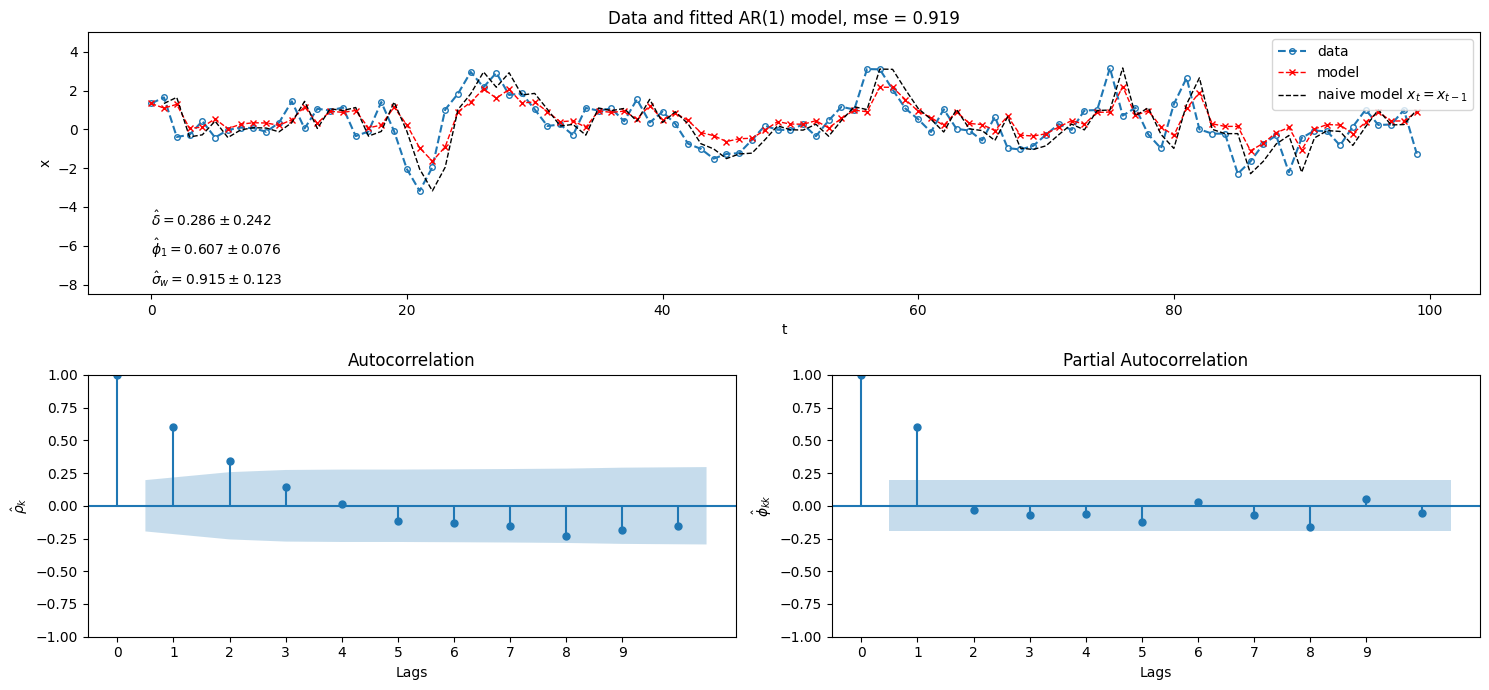

In [7]:
x = generate_toy_data(n=100, x_0=0, delta=0, phi_1=0.7, sigma=1)
model_fit = fit_ar_1(x)
plot_example(x, model_fit, plot_naive_model=True)

For comparison, here's an example with the same parameter set as above, but with negative autocorrelation $\phi_1 = -0.7$. Modelled values don't lag behind observations when $\phi_1 < 0$ because direction changes are built into the model thanks to the negative autocorrelation, which implies that high values will be surrounded by low values and _vice versa_. As above, parameter estimates are close to their actual underlying values.

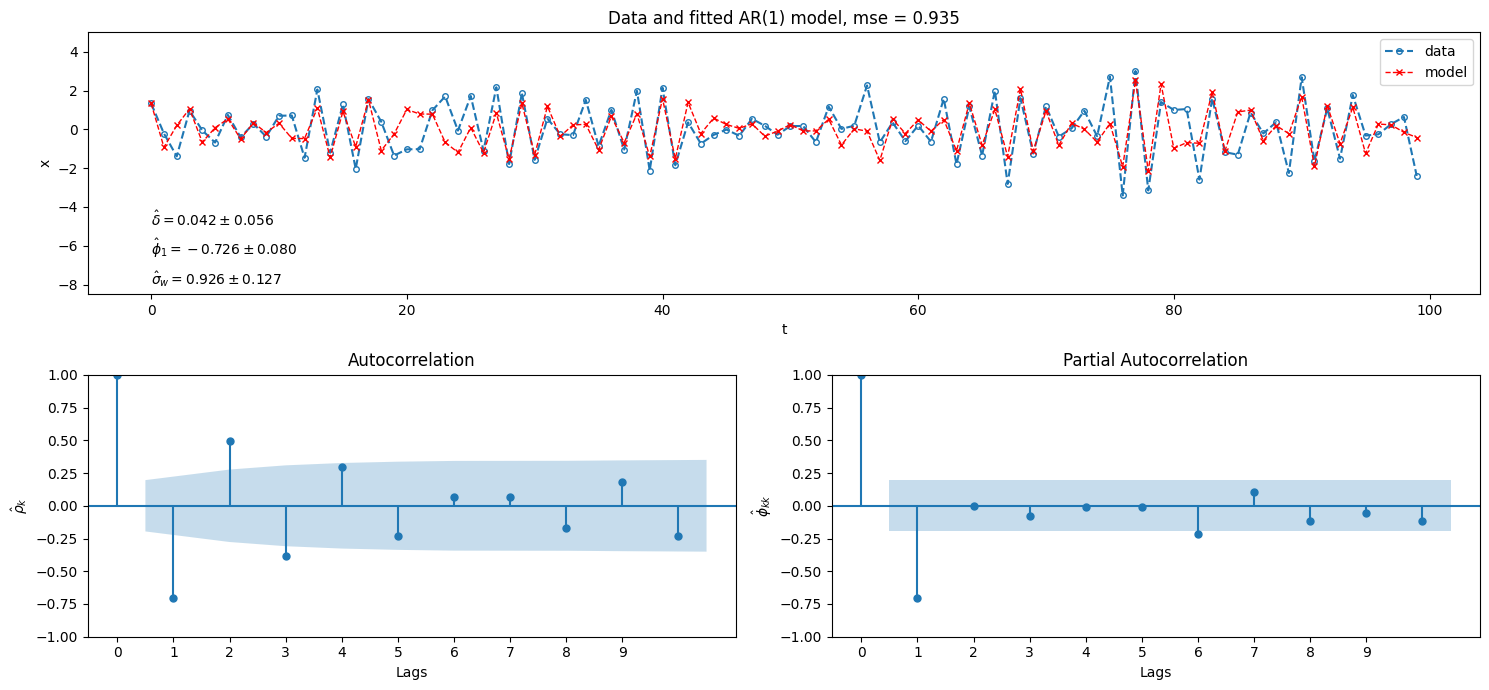

In [8]:
x = generate_toy_data(n=100, x_0=0, delta=0, phi_1=-0.7, sigma=1)
model_fit = fit_ar_1(x)
plot_example(x, model_fit, plot_naive_model=False)



#### **2.3.1. Random noise**

This is the 'elementary' stochastic process. It's just a sequence of uncorrelated random variables $w_{t}$, where each one can have a different distribution (the least constrained case) or, as is often done, we can say they all have the same distribution (*iid*), typically a normal distribution with mean 0 and some variance $\sigma_{w}^2$. In that case we write $w_{t}\sim N(0, \sigma_{w}^2)$ to say that our random noise is normally distributed with mean 0 and variance $\sigma_{w}^2)$. 

The equation for our white noise series is then

$$x_{t}=w_{t}$$

which simply says that, at every $t$, the value of the series $x_{t}$ is a draw from the distribution of $w_{t}$. This random noise series is, well, quite noisy, and is mostly just used as a model for unexplained variation (referred to as noise using an analogy from sound engineering).

#### **2.3.2. Random walk, with and without drift**

One way to introduce *smoothness* to this theoretical noisy series is to make the future a simple function of the past:

$$x_{t}=\delta+x_{t-1}+w_{t}$$

where we're simply saying that the current value $x_{t}$ is equal to the past value $x_{t-1}$ plus some constant $\delta$ (called the *drift*') plus random noise at $t$, $w_{t}$. Obviously, to apply this model we need the starting value $x_{0}$. If $\delta\neq0$, the above model is called a *random walk with drift*, whereas if $\delta=0$, the model's just called a *random walk*. Here's some R code and plots with examples for these three types of models.  



In [ ]:
# autocorrelation = cov(x_t, x_tminus1)/(sd(x_t)*sd(x_tminus1))
# ********************
# The AR(1) model
# *******************

# x_t = delta + phi_1*x_tminus1 + w_t

# assumptions:
#   - x_t weakly stationary
#   - w_t --> iid N(0, sigma_w^2)
#   - w_t independent of x

# properties:
#   - expected value E(x_t):
#     E(x_t) = E(delta + phi_1*x_tminus1 + w_t)
#     E(x_t) = E(delta) + E(phi_1*x_tminus1) + E(w_t)
#     E(x_t) = delta + phi_1*E(x_tminus1) + 0 
#     Due to stationarity, E(x_t) = E(x_tminus1). Then,
#     E(x_t) = delta / (1 - phi_1)
#
#   - variance Var(x_t):
#     Var(x_t) = Var(delta + phi_1*x_tminus1 + w_t)
#     ...assuming x_t and w_t (errors) are independent, and noting that delta and
#        phi_1 are constants:
#     Var(x_t) = 0 + Var(phi_1*x_tminus1) + Var(w_t)
#     Var(x_t) = phi_1^2*Var(x_tminus1) + sigma_w^2
#     ...assuming series is stationary, Var(x_t) = Var(x_tminus1)
#     Var(x_t) = sigma_w^2 / (1 - phi_1^2)
#
#   - autocovariance Cov(x_t, x_tminush) (h = lag):
#     ...writing x_t by substituting x_minus1 (use model without delta for simplicity)
#        going from x_t back to x_tminush
#     x_t = phi_1*x_tminus1 + w_t
#     x_t = phi_1^2*x_tminus2 + phi_1*w_tminus1 + w_t
#     x_t = phi_1^3*x_tminus3 + phi_1 2*w_tminus2 + phi_1*w_tminus1 + w_t
#     ... at t_minush:
#     x_t = phi_1^h*x_tminush + sum{i=0...h-1}(phi_1^i*w_tminusi)
#     ... substituting this for x_t in definition of cov:
#     Cov(x_t, x_tminush) = Cov(phi_1^h*x_tminush + sum{i=0...h-1}(phi_1^i*w_tminusi),
#                               x_tminush)
#     Cov(x_t, x_tminush) = Cov(phi_1^h*x_tminush, x_tminush) +
#                           Cov(sum{i=0...h-1}(phi_1^i*w_tminusi), x_tminush)
#     ... noting that the second Cov is zero, since the w_t are iid and independent
#         of the x_t, we get:
#     Cov(x_t, x_tminush) = phi_1^h*Cov(x_tminush, x_tminush) + 0
#     Cov(x_t, x_tminush) = phi_1^h*Var(x_tminush)
#     ... for AR(1), h = 1:
#     Cov(x_t, x_tminus1) = (phi_1*sigma_w^2)/(1 - phi_1^2)
#
#   - lag-1 autocorrelation = phi_1*Var(x_t)/Var(x_t) = phi_1


MA processes

ARIMA

VAR

GARCH

state-space models

LSTM
